# Trial 3 - Combined Energy and Bandwidth Metrics

Directly below is the physical craft parameters.
Secondly is the scenario setup (# of users and distribution).
The remainder are different trajectories, with their metrics graphed.


Some constraints we'll apply for this inquiry:
- Each trajectory MUST be within the 2 km radius of the origin (horizontally)
- Each trajectory MUST be between 1 km and 10 km altitude
  - Lower is, of course, better (higher density implies less power, as well as less path loss distance)
    so the constant altitude trajectories will be on that floor.
- Each trajectory MUST be perpetual with an mSoC of 40% (after our 6 hour margin)
  - This favors tighter trajectories, up to the mSoC limit from power use
- Trajectories are hand adjusted until we run into the mSoC limit, 
  and subsequently adjusted to be nearly an integer divisor of 24 hours
  
Metrics we'll get out of this:
- Throughput: min user, avg user
  
## Important Notes
- The payload power draw is probably overstated
- The aircraft mass is probably understated (TODO finish understanding the relevant Oettershagen paper)
- The battery energy density is moderately to vastly beyond that available in 2020
  (using hypothetical SionPower/Licerion advertised 650 Wh/kg cells vs 265 Wh/kg for Li-Ion [citation needed])
- Total throughput (IP layer, all UEs) is around half the calculated value (Shannon formula)
  - We've found that TCP streams, if exceeding some value, catastrophically decrease in throughput with the default NS3 config.
    UDP streams will still saturate the network.
- We are NOT (TODO should we?) optimizing the angle-of-attack for now, leaving at 5° above flow.
  - This is most likely not ideal for ascending/descending segments, but should be reasonable for horizontal with
    the airfoils we are using.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

if 'thesis.Aircraft' in sys.modules: del sys.modules['thesis.Aircraft']
from thesis.Aircraft import Aircraft

if 'thesis.Flight' in sys.modules: del sys.modules['thesis.Flight']
from thesis.Flight import Flight

# Just some figuring out how heavy we are
# https://www.doubleradius.com/site/stores/baicells/baicells-nova-233-gen-2-enodeb-outdoor-base-station-datasheet.pdf
# Unsure how massive antenna are, guessing 1 kg
# Potentially unreliable sources say that the Starlink terminal is about 12 Ibs (https://www.reddit.com/r/Starlink/comments/jqck07/how_much_does_dishy_weigh/)
m_payload = 6  # kg
# Starlink power figure https://arstechnica.com/information-technology/2020/11/spacex-starlink-beta-tester-takes-user-terminal-into-forest-gets-120mbps/
# This figure may be overstated as it is for that users "whole system" (router, other equipment included?)
# Others say 50-100 W https://www.reddit.com/r/Starlink/comments/kf8ajt/power_consumption_of_starlink/
# We compromise here with 80
P_payload = (45 + 100) * 0.75       # W

# Main contributor to performance, both from an efficiency and solar area perspective
# --Estimating 8-24 m is sufficient (summer vs winter at 45 N latitude)--
# Zephyr 7 (22.5 m span) is around 50 kg

# We are now using the Matlab code from Oettershagen to determine good/semioptimal
# parameters. Our latitude is now the top of NC, USA (the "hurricane demarcation line")
# And our reference time for sustainable flight is the end of november ("hurricane season" end)
# Summertime will, of course, be better
# We are now slightly overestimating Oettershagen (45% MSoC us vs 25% MSoC them), but
# we are using different wings and calculating the polars is a hassle. Flight power is pretty
# close (257 W us vs 221 W them). There's probably some error from our garbage integration, as well
# as our angled panels (theirs are horizontal in early design)
wingSpan = 21 # m
wingChord = wingSpan / 20.5 # m
wingArea = wingSpan * wingChord # m^2
solarFill = 0.85 # % of wing surface with solar PV
solarArea = wingArea * solarFill # Solar panel area m^2

P_solar_cap = 3000 # Maximum solar power in (W)
P_prop = 1500      # Maximum propellor power (W)

# Determined using the Oettershagen code
m_struct = 50.16


m_prop = 0.0011 * P_prop
m_solar = 0.59 * solarArea
m_mppt = 0.422 * 0.422e-3 * P_solar_cap
m_av = 1.22
bat_Wh_cap = 15.5 * 650
# From Oettershagen
#m_bat = bat_Wh_cap / 251
# From hypothetical Licerion/Sionpower Lithium-metal cells
m_bat = bat_Wh_cap / 650

mass = m_struct + m_prop + m_solar + m_mppt + m_av + m_payload + m_bat
print('Mass is %.2f kg (%.2f kg struct, %.2f kg bat)' % (mass, m_struct, m_bat))

# From NS3 defaults
radioParams = {
    'xmitPower': 30, # dBm
    'B': 180e3 * 25, # 25 180kHz RBs = 4.5 MHz
    'N0': -174       # See lte-spectrum-value-helper.cc kT_dBm_Hz
}

craft = Aircraft(mass = mass, wingSpan = wingSpan, e0 = 0.92, chord = wingChord)

print('For runner.py')
print('='*80)
print('mass, wingSpan, e0, chord = %.4f, %.4f, %.2f, %.4f' % (mass, wingSpan, 0.92, wingChord))

from thesis.Aircraft import useSimpleAltitudeModel
print(useSimpleAltitudeModel)

Mass is 85.85 kg (50.16 kg struct, 15.50 kg bat)
For runner.py
mass, wingSpan, e0, chord = 85.8526, 21.0000, 0.92, 1.0244
True


In [10]:
if 'thesis.EvalHelper' in sys.modules: del sys.modules['thesis.EvalHelper']
if 'thesis.Scenario' in sys.modules: del sys.modules['thesis.Scenario']
plt.rcParams.update({'font.size':16})
plt.rcParams.update({'text.usetex':True})

from thesis.EvalHelper import Judge
from thesis.Scenario import Scenario

scene = Scenario()
scene.addRandomGroundUsersUniformCircular(2, r = 5000)

judge = Judge(scene, craft)

#scene.render(size=50000)

#judge.displayFlightPower(flight, bat_Wh_cap, P_payload, start = '2020-11-28T08', end = '2020-11-28T19', legend=True, savename='test.pdf')
#times = pd.date_range(start = '2020-11-28T08', end = '2020-11-28T19', freq='30S', tz='America/Detroit')
#plt.figure()
#flight.toPoses(times.to_series()).tilt.plot(figsize=(18,10))



 Flight Info
1260 Second cycles, for 68 cycles with -604 left over
altitude min=1000 mean=1000 max=1000


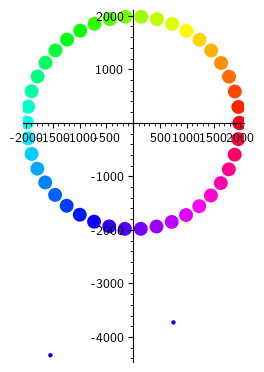



 Power info
sum solar influx: 3197301.3812523694
Power range is 396.71 to 396.71 W
mSoc = 37.66%




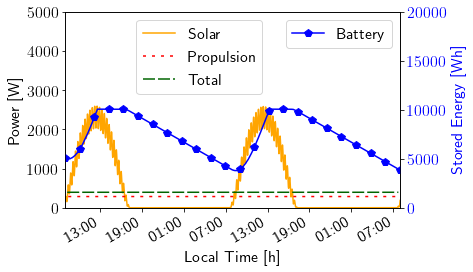

In [12]:
if 'thesis.Trajectory' in sys.modules: del sys.modules['thesis.Trajectory']
from thesis.Trajectory import CircleTrajectory
trajectory = CircleTrajectory((0, 0, 1000), 1985.8)
flight = Flight(craft, trajectory, [5 for piece in trajectory.pieces], **radioParams)

judge.displayFlightTrajectoryInfo(flight)
judge.displayFlightPower(flight, bat_Wh_cap, P_payload, start = '2020-11-28T08', end = '2020-11-30T08', legend=True, savename='energy_circle.pdf')

 Throughput (estimated) and altitude


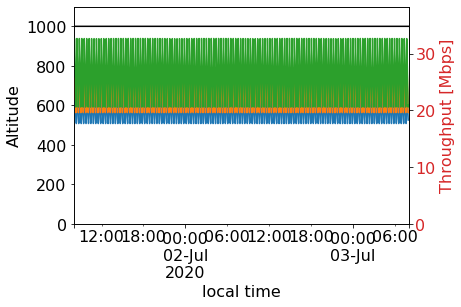

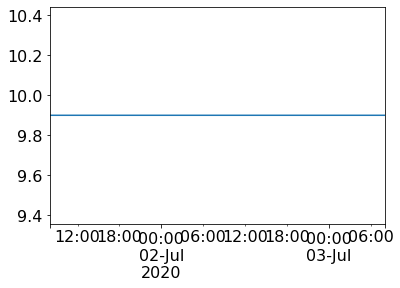

In [4]:
judge.displayFlightAltitudeThroughputInfo(flight)

 Flight Info
953 Second cycles, for 90 cycles with -326 left over
altitude min=1000 mean=1000 max=1000


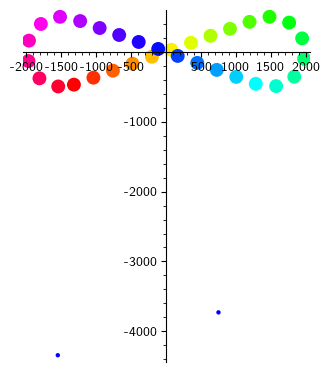



 Power info
sum solar influx: 3284622.6045689997
Power range is 395.92 to 396.01 W
mSoc = 38.00%




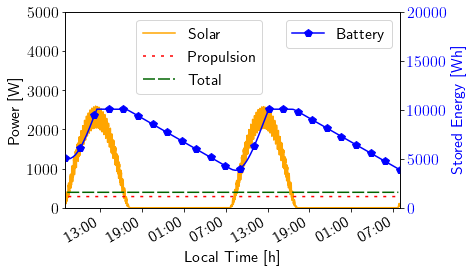

In [13]:
if 'thesis.Trajectory' in sys.modules: del sys.modules['thesis.Trajectory']
from thesis.Trajectory import BowtieTrajectory
trajectory = BowtieTrajectory((0, 0, 1000), lobeRadius = 500, lobeCenterDistance = 1485.2)
flight = Flight(craft, trajectory, [5 for piece in trajectory.pieces], **radioParams)

judge.displayFlightTrajectoryInfo(flight)
judge.displayFlightPower(flight, bat_Wh_cap, P_payload, start = '2020-11-28T08', end = '2020-11-30T08', legend=True, savename='energy_bowtie.pdf')

 Throughput (estimated) and altitude


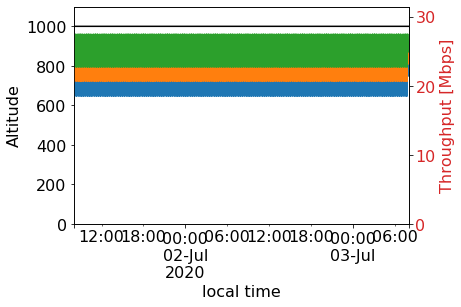

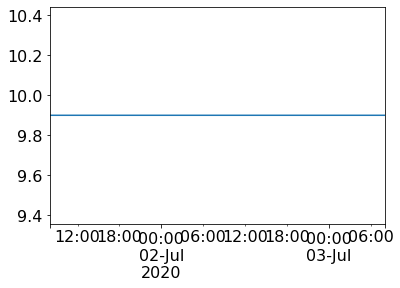

In [6]:
judge.displayFlightAltitudeThroughputInfo(flight)

 Power info
sum solar influx: 4339711.64553673
Power range is 286.42 to 566.81 W
Stored at most 1542.49 Wh = 15.31% of battery capacity as gravity potential
mSoc = 52.86%




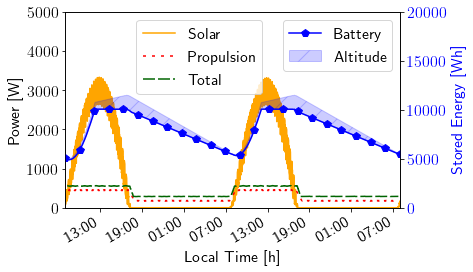

In [14]:
if 'thesis.Trajectory' in sys.modules: del sys.modules['thesis.Trajectory']
from thesis.Trajectory import SimpleLadderTrajectory

# NB, the duty cycle should roughly be adjusted to match the time when we have more solar than power out
#     (to maximize energy efficiency!)

trajectory = SimpleLadderTrajectory(
    (0, 0, 1000),
    lobeRadius = 500,
    lobeCenterDistance = 1475.45,
    stepHeight=60,
    nSteps=36,
    nStepsDown=55
)
flight = Flight(craft, trajectory, [5 for piece in trajectory.pieces], **radioParams)

#judge.displayFlightTrajectoryInfo(flight, render = False)
#judge.displayFlightTrajectoryInfo(flight, threed=True)
judge.displayFlightPower(flight, bat_Wh_cap, P_payload, start = '2020-11-28T08', end = '2020-11-30T08', legend=True, savename='energy_ladder.pdf')
#judge.displayFlightPower(flight, bat_Wh_cap, P_payload)
flight1 = flight

 Flight Info
105224 Second cycles, for 0 cycles with -18824 left over
altitude min=1000 mean=5899 max=10800


 Power info
sum solar influx: 4186453.826297049
Power range is 267.68 to 619.25 W
Stored at most 2290.36 Wh = 22.73% of battery capacity as gravity potential
mSoc = 33.62%


up to 10800.0


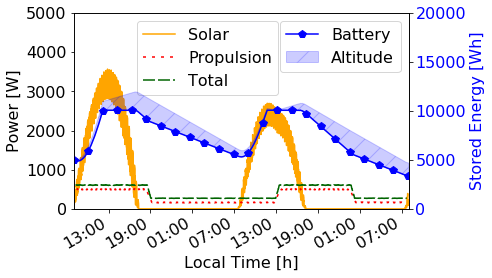

In [8]:
if 'thesis.Trajectory' in sys.modules: del sys.modules['thesis.Trajectory']
from thesis.Trajectory import SimpleLadderTrajectory

# NB, the duty cycle should roughly be adjusted to match the time when we have more solar than power out
#     (to maximize energy efficiency!)

trajectory = SimpleLadderTrajectory(
    (0, 0, 1000),
    lobeRadius = 500,
    lobeCenterDistance = 1470.7,
    stepHeight=70,
    nSteps=41,
    nStepsDown=70
)
flight = Flight(craft, trajectory, [5 for piece in trajectory.pieces], **radioParams)

judge.displayFlightTrajectoryInfo(flight, render = False)
#judge.displayFlightTrajectoryInfo(flight, threed=True)
judge.displayFlightPower(flight, bat_Wh_cap, P_payload, start = '2020-11-28T08', end = '2020-11-30T08', legend=True, savename="energy_ladder.pdf")
#judge.displayFlightPower(flight, bat_Wh_cap, P_payload)
flight3 = flight
times = pd.date_range(start = '2020-11-28T08', end = '2020-11-30T08', freq='30S', tz='America/Detroit')
p3 = flight3.toPoses(times.to_series())
print('up to', p3.z.max())

#diff = np.sqrt((p1.x-p3.x)**2 + (p1.y - p3.y)**2 + (p1.z - p3.z)**2)
#[p1.z.max(), p3.z.max(), diff.max()]

In [9]:
times = pd.date_range(start = '2020-11-28T08', end = '2020-11-30T08', freq='30S', tz='America/Detroit')
p1 = flight1.toPoses(times.to_series())
p2 = flight2.toPoses(times.to_series())

#judge.displayFlightTrajectoryInfo(flight1, render = False)
#judge.displayFlightTrajectoryInfo(flight2, render = False)
judge.displayFlightPower(flight1, bat_Wh_cap, P_payload, start = '2020-11-28T08', end = '2020-11-30T08', legend=True)
judge.displayFlightPower(flight2, bat_Wh_cap, P_payload, start = '2020-11-28T08', end = '2020-11-30T08', legend=True)


NameError: name 'flight2' is not defined

In [ ]:
np.sqrt((p1.x-p2.x)**2 + (p1.y - p2.y)**2 + (p1.z - p2.z)**2).describe()
p1.z.max()

In [ ]:
judge.displayFlightAltitudeThroughputInfo(flight)

In [ ]:
if 'thesis.Trajectory' in sys.modules: del sys.modules['thesis.Trajectory']
from thesis.Trajectory import DTrajectory

trajectory = DTrajectory((0, 0, 1000), 5000, 500, 0, False)
flight = Flight(craft, trajectory, [5 for piece in trajectory.pieces], **radioParams)

judge.displayFlightTrajectoryInfo(flight)
judge.displayFlightPower(flight, bat_Wh_cap, P_payload, start = '2020-11-28T08', end = '2020-11-30T08')

In [ ]:
if 'thesis.Trajectory' in sys.modules: del sys.modules['thesis.Trajectory']
from thesis.Trajectory import CircleTrajectory, BowtieTrajectory, SimpleLadderTrajectory

def fakeDashedLine(p1, p2, dashlength = 10, cycle = 0.25, **kwargs):
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    dz = p2[2] - p1[2]
    
    length = sqrt(dx**2 + dy**2 + dz**2)
    
    def lrp(v):
        return (
            p1[0] + dx * v,
            p1[1] + dy * v,
            p1[2] + dz * v,
        )
    
    ret = []
    
    nDashes = int(length / dashlength)
    for i in range(nDashes):
        left = i / nDashes
        right = left + cycle / nDashes
        
        ret.append(line([lrp(left), lrp(right)], **kwargs))
        
    return sum(ret)

# This trajectory is for demonstration
ladder = SimpleLadderTrajectory(
    (0, 0, 1000),
    lobeRadius = 500,
    lobeCenterDistance = 1475.45,
    stepHeight=260,
    nSteps=2
)

sum([
    ladder.renderTop(thickness=4),
    circle((0,0), 2000, color='red', linestyle='--', thickness=4),
    # Eh, we can just do figure captions like a regular person
    #text('Top View', (-1400, 2000), horizontal_alignment='center'),
    #text('Bowtie & Ladder', (-1400, 1800), horizontal_alignment='center')
]).show(figsize=(4, 4), ticks=[1000, 1000], xmin=-2000, xmax=2000, fontsize=14)

sum([
    ladder.renderSideFancy(4, thickness=4),
    #text('Side View', (-1400, 1180), horizontal_alignment='center'),
    #text('Ladder', (-1400, 1170), horizontal_alignment='center')
]).show(figsize=(4, 4), ticks=1000, xmin=-2000, xmax=2000, fontsize=14)

circleTraj = CircleTrajectory(
    #(0, 0, 1000), 1972.03
    # Exaggerrated for easier reading
    (0, 0, 1000), 1800
)
     
sum([
    circleTraj.renderTop(thickness=4),
    circle((0,0), 2000, color='red', linestyle='--', thickness=4),
    # Eh, we can just do figure captions like a regular person
    #text('Top View', (-1400, 2000), horizontal_alignment='center'),
    #text('Bowtie & Ladder', (-1400, 1800), horizontal_alignment='center')
]).show(figsize=(4, 4), ticks=[1000, 1000], xmin=-2000, xmax=2000, fontsize=14)


sum([
    ladder.render(cutoff = 8, frame=False),
    
    fakeDashedLine(
        (-1475.45, 0, 1000),
        (-1475.45, 0, 2000),
        dashlength=100,
        cycle=0.5,
        color='red'
    ),
    
    fakeDashedLine(
        ( 1475.45, 0, 1000),
        ( 1475.45, 0, 2000),
        dashlength=100,
        cycle=0.5,
        color='red'
    )
])

# show(BowtieTrajectory(
#     (200, 50, 0),
#     lobeRadius = 50,
#     lobeCenterDistance = 150
# ).render(frame=False, axes=True) + point((0, 0, 100)))

In [ ]:
times = pd.date_range(start = '2020-07-01T08', end = '2020-07-03T08', freq='30S', tz='America/Detroit').to_series()
poses = flight.toPoses(times)

poses.z.plot()

In [ ]:
[
    craft.fastStraightVelocityThrustPower(0, 5, 0, 1000)[1].n(),
    craft.straightVelocity(0, 5, 0).n(),
    craft.straightThrust(0, 5, 0).n(),
    craft.fastTurningVelocityThrustPower(15000, 5, 1000)[1].n(),
    craft.turningVelocity(15000, 5).n(),
    craft.turningThrust(15000, 5).n(),
    craft.turningRoll(15000, 5).n()
]

In [ ]:
v=craft.straightVelocity(0, 5, 0).n()
L0, D0 = craft.powerFunctions(5)
k1 = craft.k1(1000L)
L1, D1 = L0 * k1, D0 * k1
deg2rad = pi / 180

alpha = 5 * deg2rad

earth_mean_radius = 6371008.8
g0 = 9.807 * (earth_mean_radius / (earth_mean_radius + 1000))**2

[
    g0,
    n(D1 * v ** 2 / math.cos(5 * deg2rad)),
    n((-L1 * v**2 + craft._mass * g0) / math.sin(5 * deg2rad)),
    n((craft.D(α=5, v=v, h=1000)) / cos(alpha))
]